## Overfit CNN to a small subset of training data

## Load libraries & data

In [4]:
import numpy as np
import pandas as pd
import PIL
import shutil

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
all_data = pd.read_csv('../../data/all_data_info.csv')
print('shape:', all_data.shape)
all_data.head()

shape: (103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


## Mask training data 
Motivation on using all data over training — I'd like to know artist name which is not available in training data.

In [10]:
train_paintings = all_data[all_data.in_train]
train_paintings.shape

(79433, 12)

## Mask testing data 

In [11]:
test_paintings = all_data[~all_data.in_train]
test_paintings.shape

(23817, 12)

In [12]:
print('Total number of artists:', train_paintings.artist.value_counts().shape[0])

# top 20 painting styles
train_paintings.artist.value_counts()[:20]

Total number of artists: 2074


Paul Cezanne                  412
Giovanni Battista Piranesi    402
Martiros Saryan               399
Ilya Repin                    397
Camille Pissarro              393
Vincent van Gogh              392
Theophile Steinlen            389
Pierre-Auguste Renoir         388
Boris Kustodiev               388
Pyotr Konchalovsky            388
Edgar Degas                   387
Camille Corot                 387
Eugene Boudin                 387
Gustave Dore                  387
Henri Matisse                 384
Albrecht Durer                383
Claude Monet                  383
Ivan Aivazovsky               378
Pablo Picasso                 377
John Singer Sargent           377
Name: artist, dtype: int64

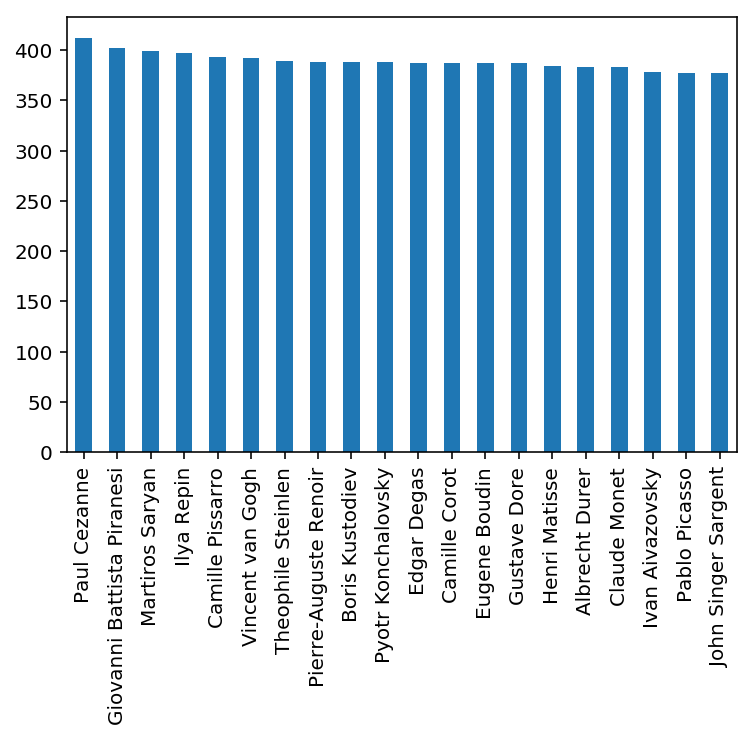

In [13]:
train_paintings.artist.value_counts()[:20].plot(kind='bar');

# Subset to Cezanne and van Gogh

#### Functions  to create subsets, arrays, and display images
- load images with keras `load_img`
- convert images to numpy arrays with `img_to_array` to manipulate (ie add, multiply, etc)
- use `array_to_img(x, data_format="channels_last")` (converts numpy array back to image)

In [36]:
def create_subset(artist, name):
    mask = train_paintings[artist] == name
    return train_paintings[mask].reset_index(drop=True)    

def create_array(subset):
    files = subset.new_filename
    return np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in files])

def display_from_array(series, array):
    for title, x in zip(series, array):
        img = array_to_img(x, data_format="channels_last")
        display(img)
        print(title)

### Create Cezanne subset

In [37]:
cezanne = create_subset('artist', 'Paul Cezanne')
print('shape:', cezanne.shape)
cezanne.head(2)

shape: (412, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg


In [38]:
cezanne.pixelsx.value_counts().head()

2536.0    59
1280.0    56
2024.0    36
3176.0    25
1576.0    14
Name: pixelsx, dtype: int64

In [39]:
cezanne.pixelsy.value_counts().head()

1024.0    37
992.0      5
960.0      5
928.0      5
1014.0     4
Name: pixelsy, dtype: int64

In [40]:
cezanne.title.value_counts().head()

Mont Sainte-Victoire          11
Self-Portrait                  6
Bathers                        6
Landscape                      5
Portrait of Madame Cezanne     5
Name: title, dtype: int64

In [41]:
cezanne.genre.value_counts().head()

landscape         165
portrait           76
still life         65
genre painting     45
self-portrait      15
Name: genre, dtype: int64

In [42]:
cezanne['style'].value_counts()

Post-Impressionism    232
Impressionism          72
Romanticism            69
Cubism                 39
Name: style, dtype: int64

### Check title for "Bathers" 
This is one of the Cezanne's most famous paintings... and there appears to be mulitple versions with the same title.

In [43]:
print(cezanne[cezanne.title.str.contains("Bathers")].shape)
cezanne[cezanne.title.str.contains("Bathers")].head()

(21, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
2,Paul Cezanne,1880,genre painting,3176.0,2939.0,1338046.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,True,46247.jpg
3,Paul Cezanne,1880,genre painting,3176.0,2874.0,1146603.0,wikiart,Post-Impressionism,Bathers,train_and_test,True,63504.jpg
4,Paul Cezanne,1906,genre painting,3176.0,2687.0,848687.0,wikiart,Cubism,Large Bathers,train_and_test,True,1695.jpg
14,Paul Cezanne,1875,genre painting,3176.0,2623.0,1074899.0,wikiart,Impressionism,Bathers,train_and_test,True,16692.jpg
22,Paul Cezanne,1870,genre painting,3176.0,2582.0,784350.0,wikiart,Romanticism,Bathers,train_and_test,True,83413.jpg


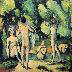

Bathers


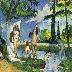

Bathers


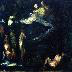

Bathers


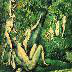

Bathers


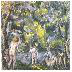

Bathers


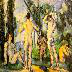

Bathers


In [44]:
bathers = cezanne[cezanne.title == "Bathers"]
bathers_array = create_array(bathers)
display_from_array(bathers.title, bathers_array)

### Create array from Cezanne images

In [45]:
cezanne_array = create_array(cezanne)
cezanne_array.shape

(412, 72, 72, 3)

### Display 5 random Cezanne paintings


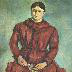

Portrait of Madame Cezanne in a Red Dress 


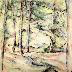

In the Woods


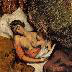

Hortense Breast Feeding Paul


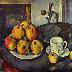

Still Life with Apples


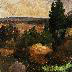

Landscape


In [46]:
rand_idx = np.random.randint(cezanne_array.shape[0], size=5)
display_from_array(cezanne.title[rand_idx], cezanne_array[rand_idx])

### Create van Gogh subset

In [47]:
vangogh = create_subset('artist', 'Vincent van Gogh')
print('shape:', vangogh.shape)
vangogh.head(2)

shape: (392, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg
1,Vincent van Gogh,1886,self-portrait,2725.0,3301.0,9226662.0,wikiart,Post-Impressionism,Self-Portrait with Dark Felt Hat at the Easel,train_and_test,True,21520.jpg


In [48]:
vangogh.pixelsx.value_counts().head()

2024.0    16
1576.0     9
1764.0     4
1767.0     4
1899.0     4
Name: pixelsx, dtype: int64

In [49]:
vangogh.pixelsy.value_counts().head()

1456.0    5
1434.0    4
2730.0    3
1842.0    3
2174.0    3
Name: pixelsy, dtype: int64

In [50]:
vangogh.title.value_counts().head()

Self-Portrait                      10
Head of a Woman                     8
Torso of Venus                      6
Peasant Woman Lifting Potatoes      4
Reaper                              4
Name: title, dtype: int64

In [51]:
vangogh.genre.value_counts().head()

landscape           88
sketch and study    81
portrait            58
genre painting      54
cityscape           31
Name: genre, dtype: int64

In [52]:
vangogh['style'].value_counts()

Post-Impressionism    229
Realism               156
Japonism                4
Cloisonnism             3
Name: style, dtype: int64

### Check title for "Starry" 
Again, arguably one of van Gogh's most famous works.

In [53]:
vangogh[vangogh.title.str.contains("Starry")]

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
65,Vincent van Gogh,1889,sketch and study,2726.0,2055.0,1699780.0,wikiart,Post-Impressionism,The Starry Night,train_and_test,True,75795.jpg
159,Vincent van Gogh,1889,cloudscape,2560.0,1600.0,2684897.0,wikiart,Post-Impressionism,The Starry Night,train_and_test,True,52390.jpg
341,Vincent van Gogh,1888,landscape,2000.0,1333.0,729732.0,wikiart,Post-Impressionism,The Starry Night,train_and_test,True,56629.jpg


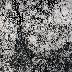

The Starry Night


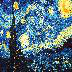

The Starry Night


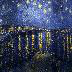

The Starry Night


In [54]:
starry = vangogh[vangogh.title == "The Starry Night"]
starry_array = create_array(starry)
display_from_array(starry.title, starry_array)

### Create array from van Gogh images

In [55]:
vangogh_array = create_array(vangogh)
vangogh_array.shape

(392, 72, 72, 3)

### Display 5 random van Gogh paintings


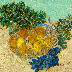

Still Life with Oranges and Lemons with Blue Gloves 


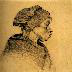

Head of a Woman


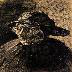

Head of a Fisherman with a Sou'wester


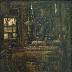

Weaver


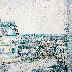

View from Vincent's room in the Rue Lepic


In [56]:
vg_rand_idx = np.random.randint(vangogh_array.shape[0], size=5)
display_from_array(vangogh.title[vg_rand_idx], vangogh_array[vg_rand_idx])

## Train a Convolutional Neural Network

### Overfit on a small subset of data 
Create subset — only 3 random paintings from Cezanne and Van Gogh (for a total of 6 training samples)

In [57]:
cezanne_vangogh_train = train_paintings[(train_paintings.artist == 'Vincent van Gogh') | (train_paintings.artist == 'Paul Cezanne')]
print(cezanne_vangogh_train.shape)
cezanne_vangogh_train.head()

(804, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1005,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1012,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg
1027,Paul Cezanne,1880,genre painting,3176.0,2939.0,1338046.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,True,46247.jpg
1066,Paul Cezanne,1880,genre painting,3176.0,2874.0,1146603.0,wikiart,Post-Impressionism,Bathers,train_and_test,True,63504.jpg
1079,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg


In [58]:
cezanne_vangogh_test = test_paintings[(test_paintings.artist == 'Vincent van Gogh') | (test_paintings.artist == 'Paul Cezanne')]
print(cezanne_vangogh_test.shape)
cezanne_vangogh_test.head()

(189, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1357,Paul Cezanne,1878,genre painting,3176.0,2618.0,1139110.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,False,19446.jpg
1377,Paul Cezanne,1894,still life,3176.0,2606.0,737724.0,wikiart,Post-Impressionism,"Curtain, Jug and Fruit",train_and_test,False,94593.jpg
1393,Paul Cezanne,1877,symbolic painting,3176.0,2600.0,958500.0,wikiart,Impressionism,The Eternal Woman,train_and_test,False,64480.jpg
1475,Paul Cezanne,c.1905,landscape,3176.0,2552.0,836544.0,wikiart,Cubism,Montagne Sainte-Victoire and the Black Chateau,train_and_test,False,71902.jpg
1478,Paul Cezanne,c.1890,landscape,3176.0,2551.0,811453.0,wikiart,Post-Impressionism,Mont Sainte-Victoire,train_and_test,False,11113.jpg


### Data set up 

In [61]:
X_files_train = cezanne_vangogh_train.new_filename
X_array_train = np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in X_files_train])
X_n_train = X_array_train / 255.

y_train = np.array(cezanne_vangogh_train.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0))

X_n_train.shape, y_train.shape

((804, 72, 72, 3), (804,))

In [62]:
X_files_test = cezanne_vangogh_test.new_filename
X_array_test = np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in X_files_test])
X_n_test = X_array_test / 255.

y_test = np.array(cezanne_vangogh_test.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0))

X_n_test.shape, y_test.shape

((189, 72, 72, 3), (189,))

### Select small sample — 6 

In [63]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_n_train, y_train, train_size=6, stratify=y_train)
X_train_sub.shape, y_train_sub.shape

((6, 72, 72, 3), (6,))

In [64]:
pd.Series(y_train_sub).value_counts()

1    3
0    3
dtype: int64

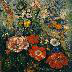

1


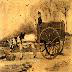

0


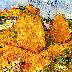

0


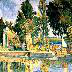

1


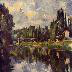

1


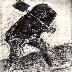

0


In [65]:
display_from_array(y_train_sub, X_train_sub)

In [66]:
model_overfit = Sequential()
model_overfit.add(Conv2D(32, (3, 3), input_shape=[72, 72, 3]))
model_overfit.add(Activation('relu'))
model_overfit.add(MaxPooling2D(pool_size=(2, 2)))

model_overfit.add(Flatten())  
model_overfit.add(Dense(1))
model_overfit.add(Activation('sigmoid'))

model_overfit.summary()
model_overfit.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 39201     
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 40,097.0
Trainable params: 40,097.0
Non-trainable params: 0.0
_________________________________________________________________


### Create callback to visualize training

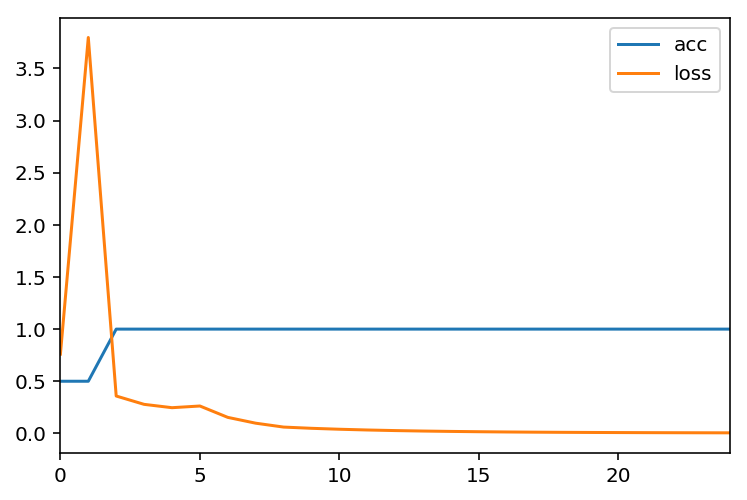

6/6 [==============================] - 0s - loss: 0.0052 - acc: 1.0000


In [67]:
class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()
        
        
model_overfit.fit(X_train_sub, y_train_sub, epochs=25, callbacks=[TrainingVisualizerCallback()])

### Train on ALL the data
This time use all paintings from each artist

In [68]:
pd.Series(y_train).value_counts()

1    412
0    392
dtype: int64

In [69]:
pd.Series(y_test).value_counts()

0    102
1     87
dtype: int64

In [70]:
# potentially use a learning rate scheduler 

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=[72, 72, 3]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 39201     
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 40,097.0
Trainable params: 40,097.0
Non-trainable params: 0.0
_________________________________________________________________


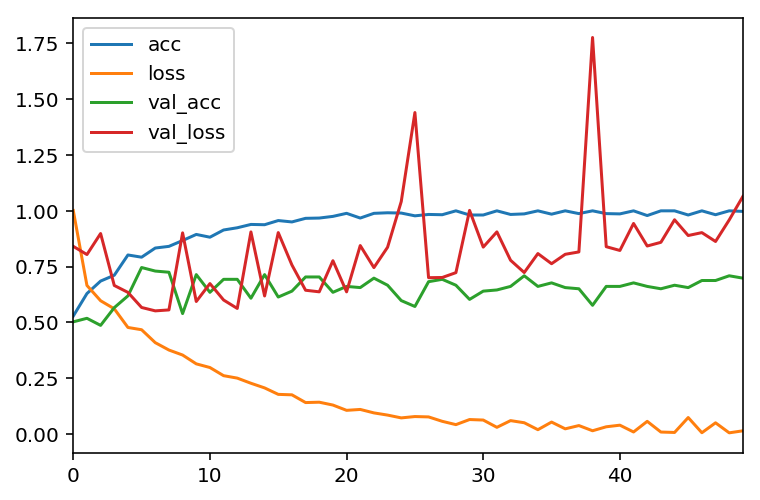

804/804 [==============================] - 3s - loss: 0.0144 - acc: 0.9975 - val_loss: 1.0645 - val_acc: 0.6984


In [71]:
# name as history, save best model — use callback
class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()
        
model.fit(X_n_train, y_train, epochs=50, validation_data=(X_n_test, y_test), callbacks=[TrainingVisualizerCallback()])

### Generalized Performance

In [72]:
print('accuracy:', model.evaluate(X_n_test, y_test))
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, model.predict_classes(X_n_test)))

160/189 [========================>.....] - ETA: 0saccuracy: [1.064510805896981, 0.69841269809732998]
-----------------------------------------------------
160/189 [========================>.....] - ETA: 0s             precision    recall  f1-score   support

          0       0.67      0.88      0.76       102
          1       0.78      0.48      0.60        87

avg / total       0.72      0.70      0.68       189



### Fix Class imbalance  
Randomly sample 392 paintings from Cezanne to match Vangogh representation in the data

(804, 12)
Paul Cezanne        412
Vincent van Gogh    392
Name: artist, dtype: int64
Paul Cezanne        0.512438
Vincent van Gogh    0.487562
Name: artist, dtype: float64


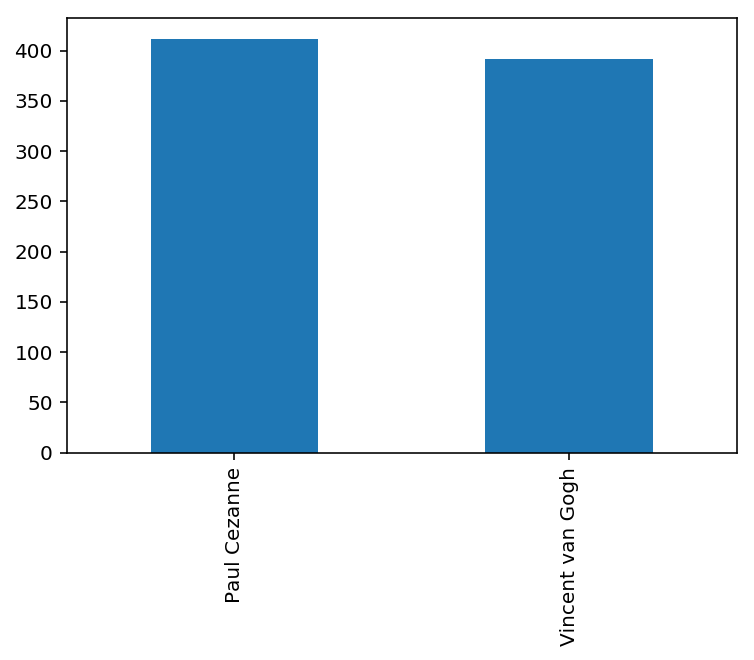

In [74]:
print(cezanne_vangogh_train.shape)
print(cezanne_vangogh_train.artist.value_counts())
print(cezanne_vangogh_train.artist.value_counts(normalize=True))
cezanne_vangogh_train.artist.value_counts().plot(kind='bar');

(189, 12)
Vincent van Gogh    102
Paul Cezanne         87
Name: artist, dtype: int64
Vincent van Gogh    0.539683
Paul Cezanne        0.460317
Name: artist, dtype: float64


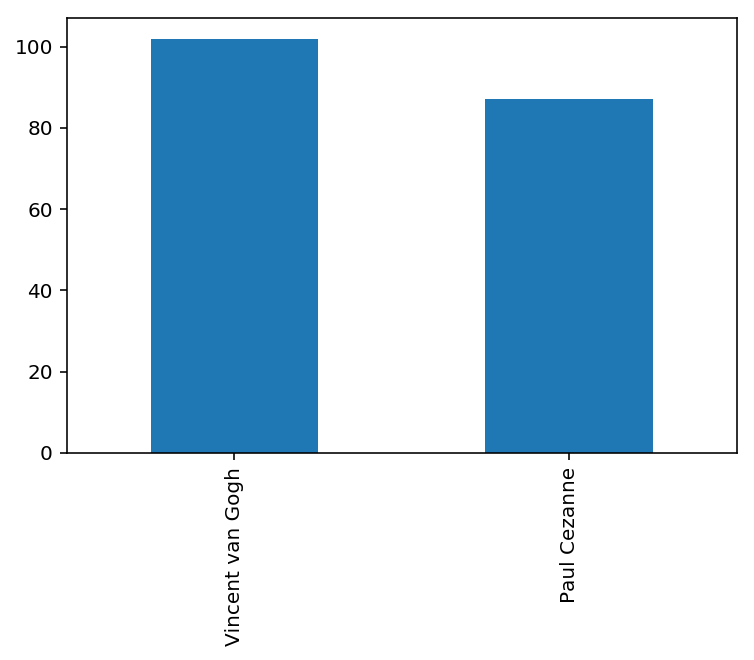

In [80]:
print(cezanne_vangogh_test.shape)
print(cezanne_vangogh_test.artist.value_counts())
print(cezanne_vangogh_test.artist.value_counts(normalize=True))
cezanne_vangogh_test.artist.value_counts().plot(kind='bar');

### Find indices random of smallest class size

In [81]:
cezanne_train_idx = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Paul Cezanne'].sample(n=392).index.values.tolist()
vangogh_train_idx = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Vincent van Gogh'].index.values.tolist()
cezanne_vangogh_train_balanced = cezanne_vangogh_train.loc[cezanne_train_idx + vangogh_train_idx, :]

Paul Cezanne        0.5
Vincent van Gogh    0.5
Name: artist, dtype: float64


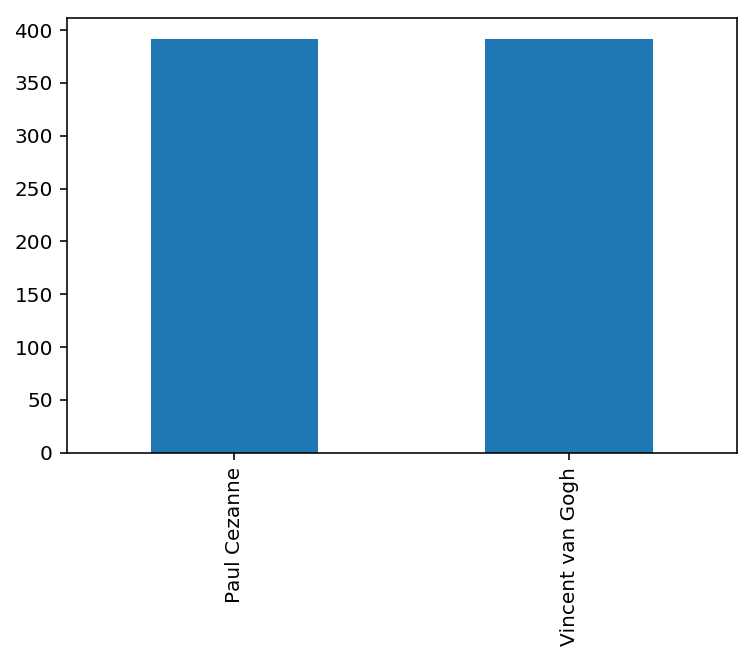

In [82]:
print(cezanne_vangogh_train_balanced.artist.value_counts(normalize=True))
cezanne_vangogh_train_balanced.artist.value_counts().plot(kind='bar');

In [83]:
cezanne_test_idx = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Paul Cezanne'].index.values.tolist()
vangogh_test_idx = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Vincent van Gogh'].sample(n=87).index.values.tolist()
cezanne_vangogh_test_balanced = cezanne_vangogh_test.loc[cezanne_test_idx + vangogh_test_idx, :]

Paul Cezanne        0.5
Vincent van Gogh    0.5
Name: artist, dtype: float64


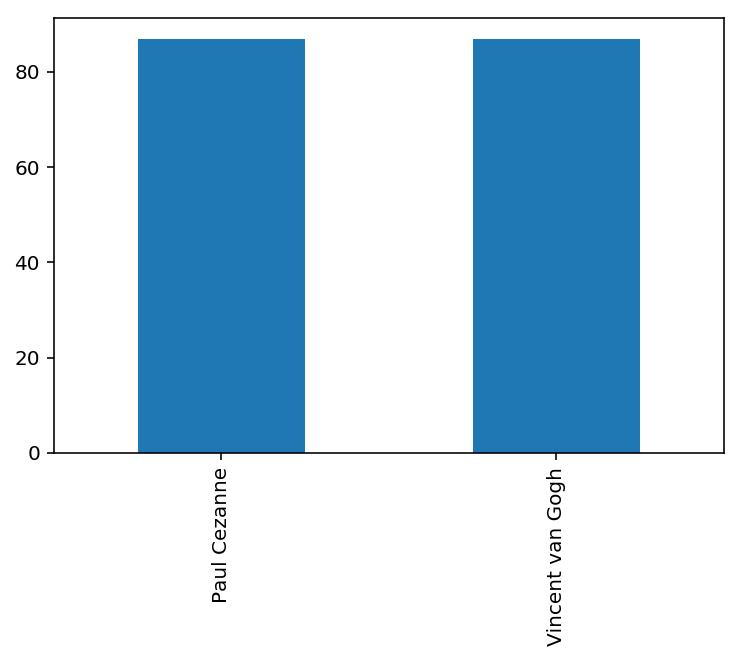

In [84]:
print(cezanne_vangogh_test_balanced.artist.value_counts(normalize=True))
cezanne_vangogh_test_balanced.artist.value_counts().plot(kind='bar');

### Train on the class balanced data
This time use 392 train paintings / 87 test paintings from each artist

In [87]:
X_files_train_balanced = cezanne_vangogh_train_balanced.new_filename
X_array_train_balanced = np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in X_files_train_balanced])
X_n_train_balanced = X_array_train_balanced / 255.

y_train_balanced = np.array(cezanne_vangogh_train_balanced.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0))

X_n_train_balanced.shape, y_train_balanced.shape

((784, 72, 72, 3), (784,))

In [88]:
X_files_test_balanced = cezanne_vangogh_test_balanced.new_filename
X_array_test_balanced = np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in X_files_test_balanced])
X_n_test_balanced = X_array_test_balanced / 255.

y_test_balanced = np.array(cezanne_vangogh_test_balanced.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0))

X_n_test_balanced.shape, y_test_balanced.shape

((174, 72, 72, 3), (174,))

In [89]:
# X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_n_balanced, y_balanced, test_size=.25, stratify=y_balanced)
# X_train_balanced.shape, y_train_balanced.shape

In [90]:
pd.Series(y_train_balanced).value_counts()

1    392
0    392
dtype: int64

In [91]:
pd.Series(y_test_balanced).value_counts()

1    87
0    87
dtype: int64

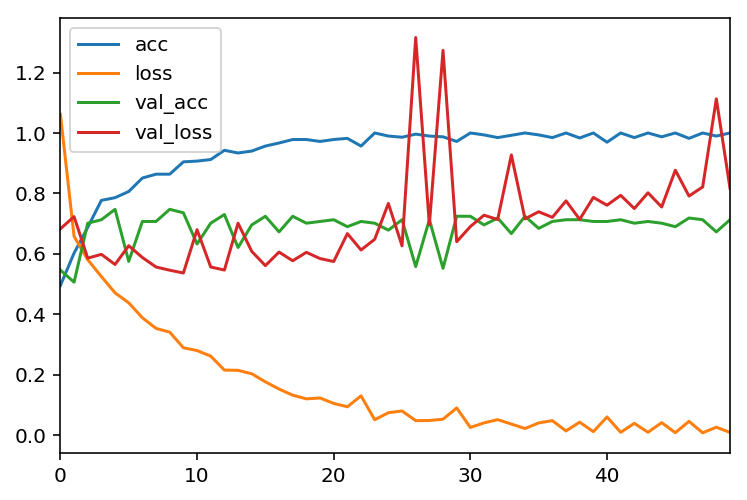

784/784 [==============================] - 3s - loss: 0.0082 - acc: 1.0000 - val_loss: 0.8172 - val_acc: 0.7126


In [92]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=[72, 72, 3]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# name as history, save best model — use callback
class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()
        
model.fit(X_n_train_balanced, y_train_balanced, epochs=50, validation_data=(X_n_test_balanced, y_test_balanced), callbacks=[TrainingVisualizerCallback()])

### Generalized Performance

In [93]:
print('accuracy:', model.evaluate(X_n_test_balanced, y_test_balanced))
print('-----------------------------------------------------')
print(metrics.classification_report(y_test_balanced, model.predict_classes(X_n_test_balanced)))

160/174 [==========================>...] - ETA: 0saccuracy: [0.8172407129715229, 0.71264367679069784]
-----------------------------------------------------
160/174 [==========================>...] - ETA: 0s             precision    recall  f1-score   support

          0       0.71      0.71      0.71        87
          1       0.71      0.71      0.71        87

avg / total       0.71      0.71      0.71       174

